In [1]:
import torch as t
import matplotlib.pyplot as plt
import numpy as np 
from tqdm import tqdm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from torch import nn
from tqdm import tqdm
import copy

In [2]:
## helper functions 


def sphere_to_cart(polar, azimuthal):
    sinx = t.sin(azimuthal)
    siny = t.sin(polar)
    cosx = t.cos(azimuthal)
    cosy = t.cos(polar)
    return t.stack((sinx*cosy, sinx*siny, cosx), -1)
    
def split_classes(data):
    A_indices = t.nonzero(data[:,-1] > 0).squeeze(1)
    B_indices = t.nonzero(data[:,-1] <= 0).squeeze(1)
    return data[A_indices].squeeze(1),  data[B_indices].squeeze(1)

def prune_classes(data):
    classA, classB = split_classes(data)
    if classA.shape[0] < classB.shape[0]:
        classB = classB[:classA.shape[0]]
    else:
        classA = classA[:classB.shape[0]]

    assert classA.shape == classA.shape
    return t.cat((classA, classB), dim=0)

# make cartesian mesh to visualize data 
def make_sphere_mesh(x, y, z, radius, res=10):
    center = t.Tensor([x,y,z]).reshape(1,1,3)
    polar = t.linspace(0, 2*t.pi, res)
    az = t.linspace(0, t.pi, res)
    Polar, Az = t.meshgrid((polar, az), indexing = 'ij')
    return sphere_to_cart(Polar, Az) * radius + center

def scatter_class(data, *args, **kwargs):
    return go.Scatter3d(x=data[:,0], y=data[:,1], z= data[:,2], *args, **kwargs)

In [3]:
def spiral_data(n_points):
    theta = 2*t.pi*t.sqrt(t.rand(n_points))
    r_a = 2*theta + t.pi
    data_a = t.stack((r_a * t.cos(theta),r_a * t.sin(theta)),dim=-1)
    x_a  = data_a + t.randn((n_points,2))
    r_b = - (2*theta + t.pi)
    data_b = t.stack((r_b * t.cos(theta),r_b * t.sin(theta)),dim=-1)
    x_b  = data_b + t.randn((n_points,2))

    ## not sure why we're adding zeros, hopefully it will become clear later
    res_a = t.cat((x_a, t.zeros((n_points,1))), dim=1)
    res_b = t.cat((x_b, t.ones((n_points,1))), dim=1)

    res = t.cat((res_a, res_b), dim=0)

    ## I don't really understand why they divide by the max of the first 3 columns 
    res[:,:-1] = res[:,:-1]/(res[:,:-1].max())
    return res[t.randperm(res.shape[0])]

def generate_spiral_sets(n_points):
    data = spiral_data(n_points)
    data = prune_classes(data)

    data = data[t.randperm(data.shape[0])]

    classA, classB = split_classes(data)

    train_frac = .8
    train_sz = int(len(data)*train_frac)

    train_data = data[:train_sz]
    test_data = data[train_sz:]
    assert len(train_data) + len(test_data) == len(data)

    return train_data, test_data, classA, classB
    

In [4]:
## nice way of building the model with modules: for each hidden layer, add a linear and normalization layer 

class SimpleNorm(nn.Module):
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps

    def forward(self,x):
        norm = t.sum(x**2, dim=-1, keepdim=True)
        return x / t.sqrt(norm + self.eps)
    
# like this, each hidden dim has the same size, could change this if we wanted? 
class DeepNNN(nn.Module):
    def __init__(self, in_dim:int, hidden_dim:int, n_hidden:int):
        super().__init__()
        modules = [nn.Linear(in_dim, hidden_dim), SimpleNorm()]
        for i in range(n_hidden):
            modules.append(nn.Linear(hidden_dim, hidden_dim))
            modules.append(SimpleNorm())

        modules.append(nn.Linear(hidden_dim, 2))

        self.ff = nn.Sequential(*modules)

    def forward(self,x):
        return self.ff(x)
    

    
def make_batches(train_data, batch_size):
    size = len(train_data) // batch_size
    ## using yield instead of return allows it to iterate over all the batches in turn 
    for i in range(size):
        yield train_data[i*batch_size:(i+1)*batch_size]
    remainder = len(train_data)% batch_size
    if remainder != 0:
        yield train_data[-remainder:]

## test model by returning the loss and accuracy 
def test(model, test_data, criterion,batch_size = 32):

    batched_data = make_batches(test_data, batch_size)
    avg_loss = 0
    acc = 0

    for batch in batched_data:
        input = batch[:,:-1]
        labels = batch[:,-1].to(t.long)
        # don't log the gradients for testing
        with t.no_grad():
            output = model(input)
        loss = criterion(output,labels)
        corr = (output.argmax(dim=-1) == labels).count_nonzero()
        avg_loss += loss.item() * len(batch)
        acc += corr.item()
    return avg_loss/len(test_data), acc/len(test_data)

def train(model, train_data, criterion, optimizer, model_checkpoints,batch_size = 32):
    train_data = train_data[t.randperm(train_data.shape[0])]
    batched_data = make_batches(train_data, batch_size)
    avg_loss = 0
    acc = 0

    for batch in batched_data:
        input = batch[:,:-1]
        labels = batch[:,-1].to(t.long)
        output = model(input)
        ## don't log the correlations for backprop
        with t.no_grad():
            corr = (output.argmax(dim=-1) == labels).count_nonzero()
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * len(batch)
        acc += corr.item()
        ## reset grads to None (saves memory)
        optimizer.zero_grad()

        #save a copy of model to checkpoints
        model_checkpoints.append(copy.deepcopy(model))

    return avg_loss/len(train_data), acc/len(train_data)




In [5]:
## plotting functions 

def decision_bound(model, n_points, bounds):
    x = t.linspace(-bounds, bounds, n_points)
    xy_grid = t.cartesian_prod(x,x)
    output = model(xy_grid).argmax(dim=-1).reshape(n_points,n_points).swapaxes(0,1)
    return x, x, output

def plot_metrics(train_loss,train_acc, test_loss, test_acc):
    fig = make_subplots(rows=2,cols=2, subplot_titles = ['Train Loss', 'Train Accuracy', 'Test Loss', 'Test Accuracy'])
    fig.add_trace(go.Scatter(y=train_loss), row=1, col=1)
    fig.add_trace(go.Scatter(y=train_acc), row=1, col=2)
    fig.add_trace(go.Scatter(y=test_loss), row=2, col=1)
    fig.add_trace(go.Scatter(y=test_acc), row=2, col=2)
    # get rid of legend
    fig.update_layout(showlegend=False)
    ## add x and y axis labels and change plot style 
    fig.update_xaxes(
        title = 'Epoch',
        zeroline=True,
        zerolinewidth=1,
        zerolinecolor='black',
        showgrid=False
    )
    fig.update_yaxes(
        title = 'Loss',
        showgrid=False,
        col=1
    )
    fig.update_yaxes(
        title = 'Accuracy',
        showgrid=False,
        col=2
    )
    fig.update_layout(
        font = dict(size =12),
        width=800,
        height =500,
        margin=dict(l=10, 
                    r = 20,
                    b=10,
                    t=20,
                    pad=0)
    )
    fig.show()


def plot_decision(classA, classB, model):
    x, y, z = decision_bound(model, 60, 1.1)

    fig = go.Figure()
    fig.add_trace(
        go.Contour(
        x = x, 
        y = y,
        z = z,
        line_color = 'black',
        line_width = 2,
        contours = dict(start=0, end=1, size=1, coloring='none')
        )
    )

    fig.add_trace(
        go.Scatter(
        x = classA[:,0],
        y = classA[:,1],
        showlegend = False,
        mode = 'markers',
        marker = dict(
        size =4,
        color = 'blue'
        )
        )
    )
    fig.add_trace(
        go.Scatter(
        x = classB[:,0],
        y = classB[:,1],
        showlegend = False,
        mode = 'markers',
        marker = dict(
        size =4,
        color = 'red'
        )
        )
    )

    fig.update_layout(
        xaxis = dict(showgrid=False),
        yaxis = dict(scaleanchor = 'x',
                    scaleratio = 1,
                    showgrid = False),
        

    )

    fig.show()

In [81]:
### train the model 
train_data, test_data, classA, classB = generate_spiral_sets(5000)


num_epochs = 80
model = DeepNNN(2,3,1)
criterion = nn.CrossEntropyLoss()
lr = 0.1
optimizer = t.optim.Adam(model.parameters(), lr=lr)
model_checkpoints = [copy.deepcopy(model)]

train_loss = []
train_acc = []
test_loss = []
test_acc = []
param_cache = []

for n in tqdm(range(num_epochs)):
    loss, acc = train(model, train_data, criterion, optimizer,model_checkpoints)
    train_loss.append(loss)
    train_acc.append(acc)
    t_loss, t_acc = test(model, test_data, criterion)
    test_loss.append(t_loss)
    test_acc.append(t_acc)
    param_cache.append(model.parameters())
print(f"train loss = {loss}, train acc = {acc}, test loss = {t_loss}, test acc = {t_acc}")


plot_metrics(train_loss,train_acc, test_loss, test_acc)

## plot decision boundary 
full_checks = model_checkpoints
plot_decision(classA, classB, model)

100%|██████████| 80/80 [00:12<00:00,  6.20it/s]

train loss = 0.03751462483871728, train acc = 0.9905, test loss = 0.05242051479592919, test acc = 0.9855


In [82]:
test = [list(param) for param in param_cache]


In [83]:
weights_1 = [test[k][0] for k in range(len(test))]
bias_1 = [test[k][1] for k in range(len(test))]
weights_2 = [test[k][2] for k in range(len(test))]
bias_2 = [test[k][3] for k in range(len(test))]
weights_3 = [test[k][4] for k in range(len(test))]
bias_3 = [test[k][5] for k in range(len(test))]
### why are these the same? 
bias_3


[Parameter containing:
 tensor([ 23.2363, -23.2868], requires_grad=True),
 Parameter containing:
 tensor([ 23.2363, -23.2868], requires_grad=True),
 Parameter containing:
 tensor([ 23.2363, -23.2868], requires_grad=True),
 Parameter containing:
 tensor([ 23.2363, -23.2868], requires_grad=True),
 Parameter containing:
 tensor([ 23.2363, -23.2868], requires_grad=True),
 Parameter containing:
 tensor([ 23.2363, -23.2868], requires_grad=True),
 Parameter containing:
 tensor([ 23.2363, -23.2868], requires_grad=True),
 Parameter containing:
 tensor([ 23.2363, -23.2868], requires_grad=True),
 Parameter containing:
 tensor([ 23.2363, -23.2868], requires_grad=True),
 Parameter containing:
 tensor([ 23.2363, -23.2868], requires_grad=True),
 Parameter containing:
 tensor([ 23.2363, -23.2868], requires_grad=True),
 Parameter containing:
 tensor([ 23.2363, -23.2868], requires_grad=True),
 Parameter containing:
 tensor([ 23.2363, -23.2868], requires_grad=True),
 Parameter containing:
 tensor([ 23.23

In [85]:
assert len(model_checkpoints) == num_epochs*len(train_data)/32+1
print(model_checkpoints[0])
test_list  = [list(model_checkpoints[i].parameters())[3].detach().numpy() for i in range(len(model_checkpoints))]


DeepNNN(
  (ff): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=True)
    (1): SimpleNorm()
    (2): Linear(in_features=3, out_features=3, bias=True)
    (3): SimpleNorm()
    (4): Linear(in_features=3, out_features=2, bias=True)
  )
)


I want to convert the loss landscape from depending on the output values (y per epoch) to depending on the model parameters. To visualize this, we need to embed the parameters in a lower dimensional space. Basically, choose two random directions (in a high dim space, these are likely to be orthogonal) and take a 2d "slice" of the loss surface.  
We can do this by interpolating the weights theta and loss function along two directions delta and eta, between x and y values alpha and beta. 
So, instead of plotting L(theta) v. theta, we plot L(theta + alpha*delta + beta*eta) v alpha and beta 

Is this the right thing? What I really want is to visualize the loss landscape across epochs (time), to see where the phase transition happens : plot above for each epoch? Or take a 1d slice v. epoch 

In [80]:
from torch.nn.utils import parameters_to_vector as Params2Vec, vector_to_parameters as Vec2Params
# actual optimal value
theta_prime= Params2Vec(model_checkpoints[81].parameters())
interp_model = DeepNNN(2,3,2)
#randomly initialized parameters (lower dimensional)
theta = Params2Vec(interp_model.parameters())

def proj(theta, alpha, beta,):
    return alpha*theta[:,None,None]*(1+beta)


x = t.linspace(0,1,20)
y = t.linspace(0,1,20)
alpha, beta = t.meshgrid(x,y)
space = proj(theta, alpha, beta)
losses = t.empty_like(space[0,:,:])

for a, _ in enumerate(x):
    print(f'alpha={a}')
    for b, _ in enumerate(y):
        print(f'beta={b}')
        Vec2Params(space[:,a,b], interp_model.parameters())
        for _, (x,y, label) in enumerate(train_data):
            with t.no_grad():
                interp_model.eval()
                #print(criterion(interp_model(t.stack([x,y])),label.to(t.long)))
                losses[a][b] = criterion(interp_model(t.stack([x,y])),label.to(t.long)).item()


alpha=0
beta=0
beta=1
beta=2
beta=3
beta=4
beta=5
beta=6
beta=7
beta=8
beta=9
beta=10
beta=11
beta=12
beta=13
beta=14
beta=15
beta=16
beta=17
beta=18
beta=19
alpha=1


TypeError: iteration over a 0-d tensor

In [79]:
losses,x

(tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  3.0686e-01,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 2.6910e-03,  1.3483e-11,  9.8439e-12,  9.8439e-12,  9.8439e-12,
           9.8439e-12,  9.8439e-12,  9.8439e-12,  9.8439e-12,  9.8439e-12,
           9.8439e-12,  9.8439e-12,  9.8439e-12,  9.8439e-12,  9.8439e-12,
           9.8439e-12,  9.8439e-12,  9.8439e-12,  9.8439e-12,  9.8439e-12],
         [ 2.7911e+32,  8.1714e+20,  3.2145e-18,  1.8254e+17,  2.5639e-09,
           2.6910e-03,  4.0749e+12,  3.6710e+03,  4.7427e+30,  6.4195e-10,
           7.9811e-10,  1.3563e-19,  1.3563e-19,  1.3563e-19,  1.3563e-19,
           1.3563e-19,  1.3563e-19,  1.3563e-19,  1.3563e-19,  4.2016e+30],
         [ 1.0579e+21,  1.9938e-19,  1.8969e+31,  7.1463e+22,  7.5551e+31,
           1.0899e+27,

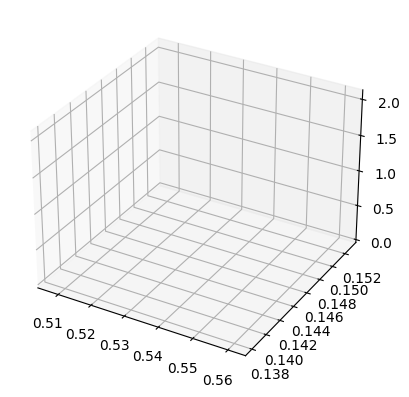

In [77]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x,y,losses)
plt.show()